In this notebook, we will play with the models.

In [58]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib

model_utils.fix_random(42)

In [4]:
train_data = data.CIFAKEDataset(root_dir="data/CIFAKE", split="train")
test_data = data.CIFAKEDataset(root_dir="data/CIFAKE", split="test")

In [5]:
# import model to finetune
model = model_utils.FTModel(model=resnet18(weights='IMAGENET1K_V1'), num_classes=1)
device = model_utils.get_device()
print(f"using {device} device")
model.model.to(device)

LEARNING_RATE = 3e-4
EPOCHS = 10
BATCH_SIZE = 128

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.model.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, test_dataloader)

using cuda device


In [ ]:
# N.B.: the loss displayed is the testing loss! (not train unless specified)
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, model.model, "FTResNet18", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

In [9]:
model_utils.test(test_dataloader, model.model, loss_fn, device)

Test Error:
 Accuracy: 74.9%, Avg loss: 0.521779 



(0.521778639334782, tensor(0.7490, device='cuda:0'))

<class 'list'> <class 'list'>
[tensor(0.5875, device='cuda:0'), tensor(0.6702, device='cuda:0'), tensor(0.7031, device='cuda:0'), tensor(0.7198, device='cuda:0'), tensor(0.7285, device='cuda:0'), tensor(0.7332, device='cuda:0'), tensor(0.7385, device='cuda:0'), tensor(0.7426, device='cuda:0'), tensor(0.7449, device='cuda:0'), tensor(0.7469, device='cuda:0')] [tensor(0.6379, device='cuda:0'), tensor(0.6859, device='cuda:0'), tensor(0.7145, device='cuda:0'), tensor(0.7229, device='cuda:0'), tensor(0.7319, device='cuda:0'), tensor(0.7384, device='cuda:0'), tensor(0.7458, device='cuda:0'), tensor(0.7455, device='cuda:0'), tensor(0.7527, device='cuda:0'), tensor(0.7490, device='cuda:0')]


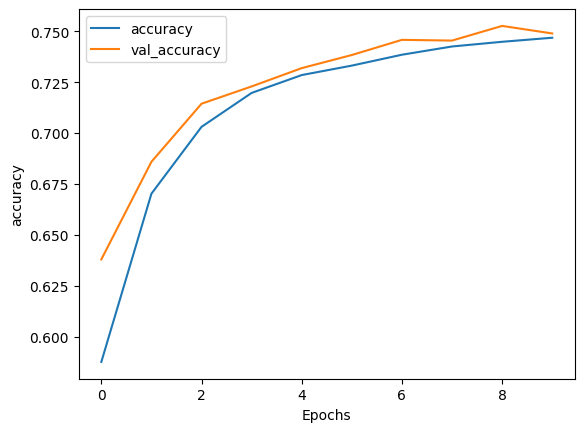

In [17]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

ResNet50 with AdamW

In [7]:
model = model_utils.FTModel(model=resnet50(weights='IMAGENET1K_V1'), num_classes=1)
model.model.to(device)

optimizer = torch.optim.AdamW(model.model.fc.parameters(), lr=LEARNING_RATE)

In [8]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, model.model, "FTResNet50", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

c:\Users\ASUS\Desktop\ethics_2\ethics_project2\model_utils.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [9]:
model_utils.test(test_dataloader, model.model, loss_fn, device)

Test Error:
Accuracy: 82.7%, Avg loss: 0.388036 



(0.3880356218025183, tensor(0.8271, device='cuda:0'))

<class 'list'> <class 'list'>
[tensor(0.7677, device='cuda:0'), tensor(0.8009, device='cuda:0'), tensor(0.8088, device='cuda:0'), tensor(0.8155, device='cuda:0'), tensor(0.8170, device='cuda:0'), tensor(0.8195, device='cuda:0'), tensor(0.8219, device='cuda:0'), tensor(0.8232, device='cuda:0'), tensor(0.8241, device='cuda:0'), tensor(0.8239, device='cuda:0')] [tensor(0.8005, device='cuda:0'), tensor(0.8093, device='cuda:0'), tensor(0.8178, device='cuda:0'), tensor(0.8199, device='cuda:0'), tensor(0.8226, device='cuda:0'), tensor(0.8227, device='cuda:0'), tensor(0.8275, device='cuda:0'), tensor(0.8271, device='cuda:0'), tensor(0.8251, device='cuda:0'), tensor(0.8295, device='cuda:0')]


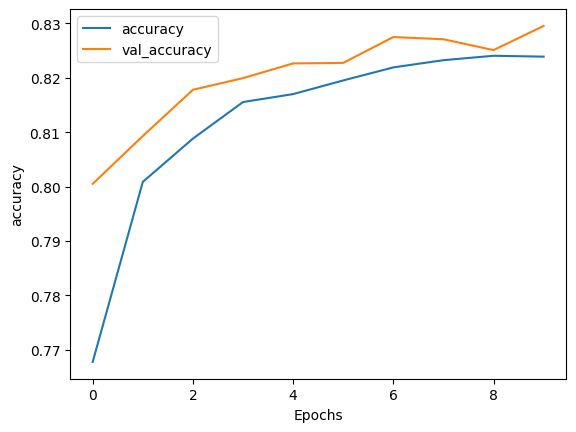

In [25]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

Lime xAI test

In [59]:
import xai
importlib.reload(xai)

xai.device = device

100%|██████████| 1000/1000 [00:01<00:00, 813.86it/s]


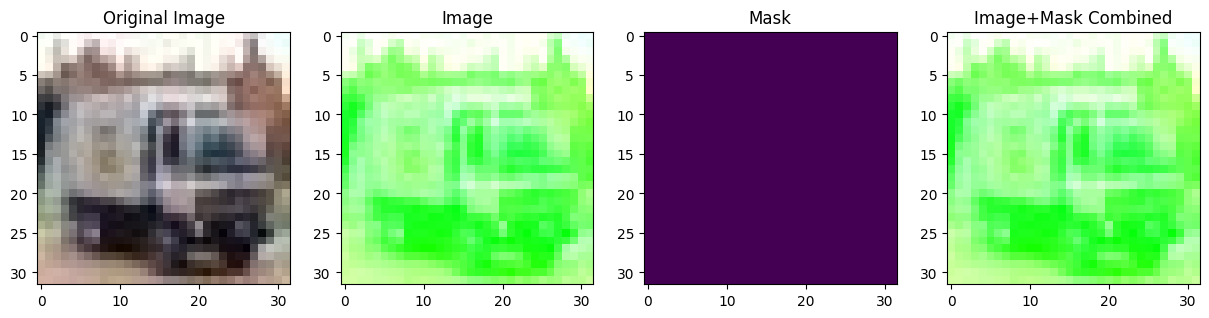

In [60]:
model.model.eval()
xai.explain_lime_single_image(test_dataloader, model.model)


TODO: fix lime. I think the problem is in the batch_predict function, which does not give the right prediction

XAi test 2 with grad_cam


AblationCAM:


100%|██████████| 64/64 [00:01<00:00, 58.56it/s]


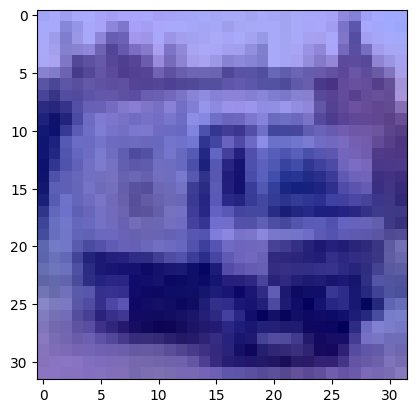

In [67]:
#exacute gradcam on last layer of resnet
xai.explain_gradcam_single_image(test_dataloader, model.model, model.model.layer4)

seems the issue is similar for gradcam, however in the notebook it is also shown that some of the examples of the batch do not have a significant gradcam. It may be the case for this image. We should see why this happens.